# ДЗ10 — Взаємна інформація та важливість ознак



In [2]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

## Завантаження даних

In [4]:
from google.colab import files
import io

uploaded = files.upload()
# data = pickle.load(io.BytesIO(uploaded['mod_05_topic_10_various_data.pkl']))


Saving mod_05_topic_10_various_data.pkl to mod_05_topic_10_various_data (2).pkl


In [5]:
with open('mod_05_topic_10_various_data.pkl', 'rb') as fl:
    datasets = pickle.load(fl)

df = datasets['autos']

## Визначення дискретних ознак

In [6]:
features = df.drop(columns='price').columns.tolist()

cat_cols = df[features].select_dtypes(include='object').columns.tolist()
print('Категоріальні:', cat_cols)

discrete_num_cols = ['num_of_doors', 'num_of_cylinders']
print('Дискретні числові:', discrete_num_cols)

discrete_cols = cat_cols + discrete_num_cols
discrete_mask = np.array([col in discrete_cols for col in features])
print('\nDiscrete mask:', dict(zip(features, discrete_mask)))

Категоріальні: ['make', 'fuel_type', 'aspiration', 'body_style', 'drive_wheels', 'engine_location', 'engine_type', 'fuel_system']
Дискретні числові: ['num_of_doors', 'num_of_cylinders']

Discrete mask: {'make': np.True_, 'fuel_type': np.True_, 'aspiration': np.True_, 'num_of_doors': np.True_, 'body_style': np.True_, 'drive_wheels': np.True_, 'engine_location': np.True_, 'wheel_base': np.False_, 'length': np.False_, 'width': np.False_, 'height': np.False_, 'curb_weight': np.False_, 'engine_type': np.True_, 'num_of_cylinders': np.True_, 'engine_size': np.False_, 'fuel_system': np.True_, 'bore': np.False_, 'stroke': np.False_, 'compression_ratio': np.False_, 'horsepower': np.False_, 'peak_rpm': np.False_, 'city_mpg': np.False_, 'highway_mpg': np.False_}


## Підготовка даних

In [7]:
X = df.drop(columns='price').copy()
y = df['price']

encoder = OrdinalEncoder()
X[cat_cols] = encoder.fit_transform(X[cat_cols])

X.head()

,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,...,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
0,0.0,1.0,0.0,2,0.0,2.0,0.0,88.6,168.8,64.1,...,4,130,4.0,3.47,2.68,9,111,5000,21,27
1,0.0,1.0,0.0,2,0.0,2.0,0.0,88.6,168.8,64.1,...,4,130,4.0,3.47,2.68,9,111,5000,21,27
2,0.0,1.0,0.0,2,2.0,2.0,0.0,94.5,171.2,65.5,...,6,152,4.0,2.68,3.47,9,154,5000,19,26
3,1.0,1.0,0.0,4,3.0,1.0,0.0,99.8,176.6,66.2,...,4,109,4.0,3.19,3.40,10,102,5500,24,30
4,1.0,1.0,0.0,4,3.0,0.0,0.0,99.4,176.6,66.4,...,5,136,4.0,3.19,3.40,8,115,5500,18,22


## Mutual Information

In [8]:
mi_scores = mutual_info_regression(X, y, discrete_features=discrete_mask, random_state=42)
mi_df = pd.DataFrame({'feature': features, 'MI': mi_scores}).sort_values('MI', ascending=False)
mi_df

,feature,MI
11,curb_weight,0.911713
14,engine_size,0.900925
19,horsepower,0.891165
22,highway_mpg,0.887362
21,city_mpg,0.774127
9,width,0.679991
8,length,0.612483
7,wheel_base,0.588635
0,make,0.543268
16,bore,0.497420


## Модель для важливості ознак

In [9]:
model = GradientBoostingRegressor(random_state=42)
model.fit(X, y)

fi_df = pd.DataFrame({'feature': features, 'Model Importance': model.feature_importances_}).sort_values('Model Importance', ascending=False)
fi_df

,feature,Model Importance
14,engine_size,0.627867
11,curb_weight,0.171675
19,horsepower,0.048444
22,highway_mpg,0.030372
9,width,0.020232
13,num_of_cylinders,0.016927
0,make,0.016760
8,length,0.013035
7,wheel_base,0.011842
21,city_mpg,0.006749


## Масштабування через rank

In [10]:
comparison = pd.DataFrame({
    'feature': features,
    'MI': mi_scores,
    'Model Importance': model.feature_importances_
}).set_index('feature')

ranked = comparison.rank(pct=True)
ranked.sort_values('MI', ascending=False)

,MI,Model Importance
feature,,
curb_weight,1.000000,0.956522
engine_size,0.956522,1.000000
horsepower,0.913043,0.913043
highway_mpg,0.869565,0.869565
city_mpg,0.826087,0.608696
width,0.782609,0.826087
length,0.739130,0.695652
wheel_base,0.695652,0.652174
make,0.652174,0.739130


## Візуалізація

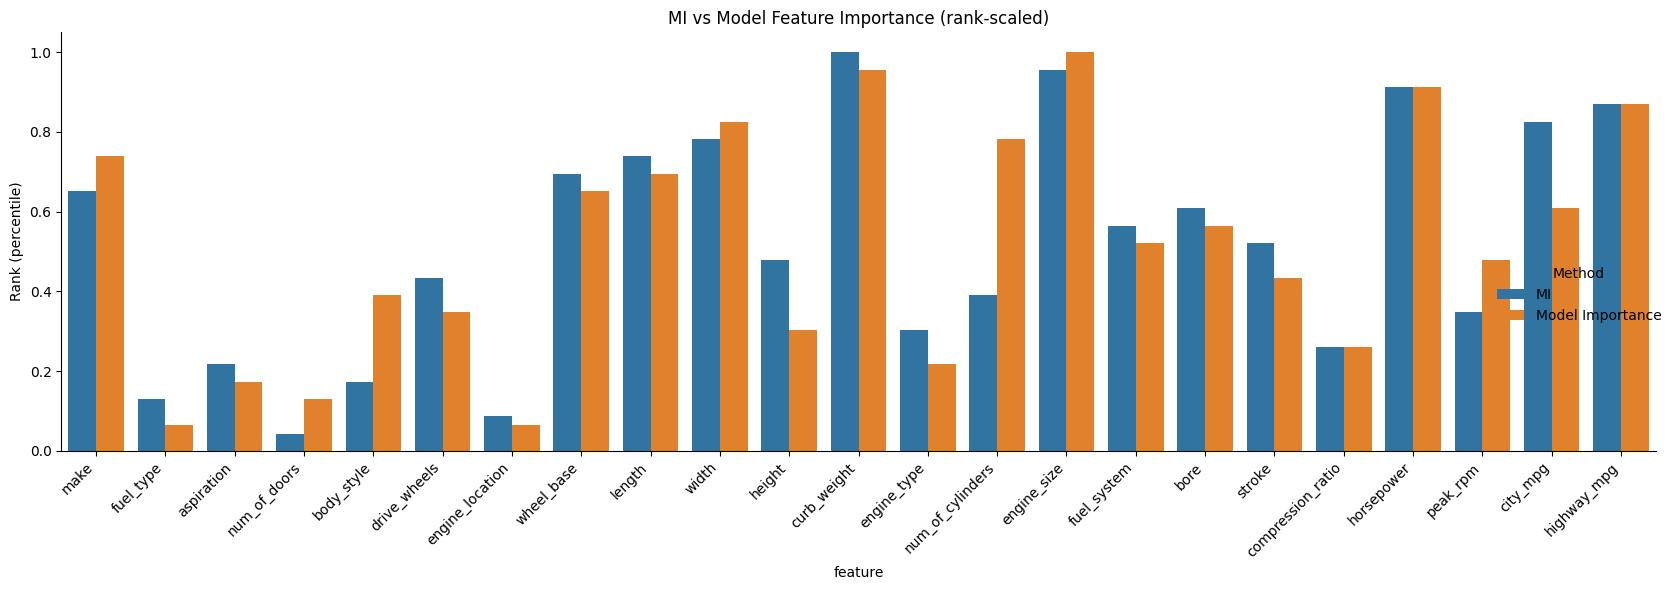

In [11]:
plot_data = ranked.reset_index().melt(id_vars='feature', var_name='Method', value_name='Rank (percentile)')

g = sns.catplot(
    data=plot_data,
    x='feature', y='Rank (percentile)', hue='Method',
    kind='bar', height=6, aspect=2.5
)
g.set_xticklabels(rotation=45, ha='right')
g.set(title='MI vs Model Feature Importance (rank-scaled)')
plt.tight_layout()
plt.show()

## Висновки

**Mutual Information (MI)** — model-agnostic метод, який вимірює статистичну залежність між кожною ознакою та цільовою змінною окремо, не враховуючи взаємодію ознак між собою.

**Model-based Feature Importance (GBR)** — враховує взаємодію ознак та їхню комбіновану предиктивну силу в контексті конкретної моделі.

**Спільне:** Обидва методи виділяють `engine_size`, `curb_weight`, `horsepower` як найважливіші ознаки для прогнозування ціни автомобіля.

**Розбіжності:** MI може надавати вищий ранг ознакам, які мають сильну індивідуальну кореляцію з ціною, тоді як GBR може знижувати їх вагу через мультиколінеарність (дублювання інформації). Навпаки, деякі ознаки з низьким MI можуть виявитися важливими у моделі через взаємодію з іншими ознаками.

**Рекомендація:** Використовувати обидва підходи для комплексної оцінки важливості ознак.